<a href="https://colab.research.google.com/github/GusSampaio/Classificacao_Multirrotulo_no_Dominio_Juridico/blob/main/Minera%C3%A7%C3%A3o_de_Textos_para_Dom%C3%ADnio_Jur%C3%ADdico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Extensionista - Classificação Multirrótulo no Domínio Jurídico

O objetivo deste projeto é desenvolver uma solução de classificação multirrótulo aplicada ao domínio jurídico. Em particular, trabalharemos com processos que podem estar associados a múltiplos assuntos, o que exige uma abordagem específica para lidar com esse tipo de dados.


In [ ]:
# Baixando e importando bibliotecas necessarias
%pip install iterative-stratification
%pip install -U sentence-transformers
%pip install scikit-multilearn-ng

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from torch.utils.data import DataLoader
import gc
from scipy import sparse

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModel, AutoModelForPreTraining
import concurrent.futures

from skmultilearn.adapt import MLkNN
from sklearn.metrics import f1_score, classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.2.1
    Uninstalling sentence-transformers-3.2.1:
      Successfully uninstalled sentence-transformers-3.2.1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 6.4 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=aeb66b27422347778c68d9f126a9093552177a25e975813640643920a0599210
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


# Leitura da Base de Dados

In [ ]:
# Baixando bases de dados de treino
!gdown 1E_aecYDw69UgYbgzQCjtP9rWonwpyFuJ
!gdown 1--unYhhi0HoMFT4kNyf91WwckjlTedYo

Downloading...
From (original): https://drive.google.com/uc?id=1E_aecYDw69UgYbgzQCjtP9rWonwpyFuJ
From (redirected): https://drive.google.com/uc?id=1E_aecYDw69UgYbgzQCjtP9rWonwpyFuJ&confirm=t&uuid=8cf24856-2be7-400e-a5b9-193890038377
To: /content/X_train.pkl
100% 878M/878M [00:16<00:00, 53.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1--unYhhi0HoMFT4kNyf91WwckjlTedYo
From (redirected): https://drive.google.com/uc?id=1--unYhhi0HoMFT4kNyf91WwckjlTedYo&confirm=t&uuid=8b1550e0-6e5b-4194-b466-0a30ead7b2d4
To: /content/Y_train.pkl
100% 138M/138M [00:02<00:00, 66.3MB/s]


In [ ]:
X_train = pd.read_pickle("X_train.pkl")
y_train = pd.read_pickle("Y_train.pkl")

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [ ]:
# Baixando embeddings gerados pelos modelos
!gdown 18MiukD3O4BCS2ijsNrHyQSn2YLUpb1ai
!gdown 1XFVCu3o5xy_PtyKagzOVe1xzv9rfZaaJ
!gdown 1s8tX1t1QWdWK2LqAhOa24lvBKGvhshDB
!gdown 1IZVL10FlM3SULIkjcwvNWjW7BXBvAsm5
!gdown 1DCFWP35T78IrEJvBH4905BnyUXQIYYl-
!gdown 16VvZA-glO5PuhQvNNuh7CpPuLFU0SfCX

Downloading...
From: https://drive.google.com/uc?id=114triivvtolove97dpOlkBM0jvdMoxtw
To: /content/X_test_multilingual_embeddings.npy
100% 84.8M/84.8M [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PGmvQLL6-9Z1ywov-bDXn9TuqeW6y8OJ
To: /content/X_test_multilingual2_embeddings.npy
100% 84.8M/84.8M [00:01<00:00, 57.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ro7KCG6gPscLwm2tSpt43kLpc4pt1cS9
From (redirected): https://drive.google.com/uc?id=1ro7KCG6gPscLwm2tSpt43kLpc4pt1cS9&confirm=t&uuid=0a9ec696-48ef-4960-bd5b-8209061e83f5
To: /content/X_train_multilingual_embeddings.npz
100% 135M/135M [00:01<00:00, 131MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1qL5uThBLIf0_xIA8jzQPdnNEqlP-fc1I
From (redirected): https://drive.google.com/uc?id=1qL5uThBLIf0_xIA8jzQPdnNEqlP-fc1I&confirm=t&uuid=a2f51888-49a0-41db-8892-fb01fbf83a45
To: /content/X_train_multilingual2_embeddings.npy
100% 169M/169M [00:01<00:00, 85.6MB/s]
Download

In [ ]:
X_train_multilingual_embeddings = np.load("X_train_multilingual_embeddings.npz")["arr_0"]
X_val_multilingual_embeddings = np.load("X_val_multilingual_embeddings.npz")["arr_0"]
X_train_multilingual2_embeddings = np.load("X_train_multilingual2_embeddings.npy")
X_val_multilingual2_embeddings = np.load("X_val_multilingual2_embeddings.npy")
X_test_multilingual_embeddings = np.load("X_test_multilingual_embeddings.npy")
X_test_multilingual2_embeddings = np.load("X_test_multilingual2_embeddings.npy")

In [ ]:
# Baixando dados de teste
!gdown 1QfrgY6HDhRk2XN_YESE36xzI7lqVawj7
!gdown 1-1t9vToIC9JnzS03mzwLLUS0xnS3egWG

Downloading...
From (original): https://drive.google.com/uc?id=1QfrgY6HDhRk2XN_YESE36xzI7lqVawj7
From (redirected): https://drive.google.com/uc?id=1QfrgY6HDhRk2XN_YESE36xzI7lqVawj7&confirm=t&uuid=841a1e5d-eb07-4ef6-95d3-bb36c83c57eb
To: /content/X_test.pkl
100% 253M/253M [00:04<00:00, 54.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1t9vToIC9JnzS03mzwLLUS0xnS3egWG
To: /content/Y_test.pkl
100% 34.4M/34.4M [00:00<00:00, 90.0MB/s]


In [ ]:
X_test = pd.read_pickle("X_test.pkl")
y_test = pd.read_pickle("Y_test.pkl")

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
train_positions = np.random.choice(len(X_train), size=30000, replace=False)
test_positions = np.random.choice(len(X_test), size=5000, replace=False)

X_train_sample = X_train.loc[train_positions]
y_train_sample = y_train.loc[train_positions]
X_test_sample = X_test.loc[test_positions]
y_test_sample = y_test.loc[test_positions]

## Análise Exploratória Descritiva

In [ ]:
X_train_sample.head()

,texto
208168,Decisão Trata-se de Agravo contra decisão que ...
131189,DECISÃO REPERCUSSÃO GERAL ADMITIDA – MATÉRIA I...
150532,DECISÃO: Vistos. Trata-se de agravo contra a d...
95521,Trata-se de agravo de instrumento contra decis...
210100,Ementa: 1. O caso em julgamento. 2. O preceden...


In [ ]:
x_train_size = X_train_sample.shape[0]
print("Tamanho do conjunto de treino:",x_train_size,'textos diferentes')

Tamanho do conjunto de treino: 30000 textos diferentes


In [ ]:
y_train_sample.head()

,DIREITO DO TRABALHO,SISTEMA REMUNERATORIO E BENE,RMI RENDA MENSAL INICIAL REAJUSTES E REVISOES ESPECIFICAS,ATOS PROCESSUAIS,RESPONSABILIDADE CIVIL,COFINSDIREITO TRIBUTARIO,DIREITO PROCESSUAL PENAL,ATOS ADMINISTRATIVOS,CONTRIBUICOES PREVIDENCIARIAS,LIMITACOES AO PODER DE TRIBUTAR,...,CRIMES DE LAVAGEM OU OCULTACAO DE BE,DIREITO ADMINISTRATIVO E OUTRAS MATERIAS DE DIREITO PUBLICO,APOSENTADORIA,RESCISAO DO CONTRATO DE TRABALHO,CRIMES PREVISTOS NA LEGISLACAO EXTRAVAGANTE,BENEFICIOS EM ESPECIE,PARTES E PROCURADORES,MAGISTRATURA,PRISAO PREVENTIVA,EXCESSO DE PRAZO PARA INSTRUCAO / JULGAMENTO
208168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150532,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
95521,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
210100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
print("Exemplo de texto jurídico:")
display(X_train_sample.loc[208168].texto)

print("\nClasses atribuídas a ele:")
for index, row in pd.DataFrame(y_train.loc[0]).iterrows():
  if row[0] != 0:
    print(row.name)

Exemplo de texto jurídico:


'Decisão Trata-se de Agravo contra decisão que inadmitiu Recurso Extraordinário interposto com fundamento no art. 102, III, alínea “a” da Constituição Federal, em que a parte recorrente alega ter o acórdão recorrido violado dispositivos constitucionais. É o relatório. Decido. De início, pontuo que em relação aos artigos 37, § 6º, e 102, I, “a”, da CF/88, o Juízo de origem não analisou a questão constitucional veiculada, não tendo sido esgotados todos os mecanismos ordinários de discussão, INEXISTINDO, portanto, o NECESSÁRIO PREQUESTIONAMENTO EXPLÍCITO, que pressupõe o debate e a decisão prévios sobre o tema jurígeno constitucional versado no recurso. Incidência das Súmulas 282 (É inadmissível o recurso extraordinário, quando não ventilada, na decisão recorrida, a questão federal suscitada) e 356 (O ponto omisso da decisão, sobre o qual não foram opostos embargos declaratórios, não pode ser objeto de recurso extraordinário, por faltar o requisito do prequestionamento), ambas desta CORTE


Classes atribuídas a ele:
REGIME ESTATU
SERVIDOR PUBLICO CIVIL
DIREITO ADMINISTRATIVO E OUTRAS MATERIAS DE DIREITO PUBLICO


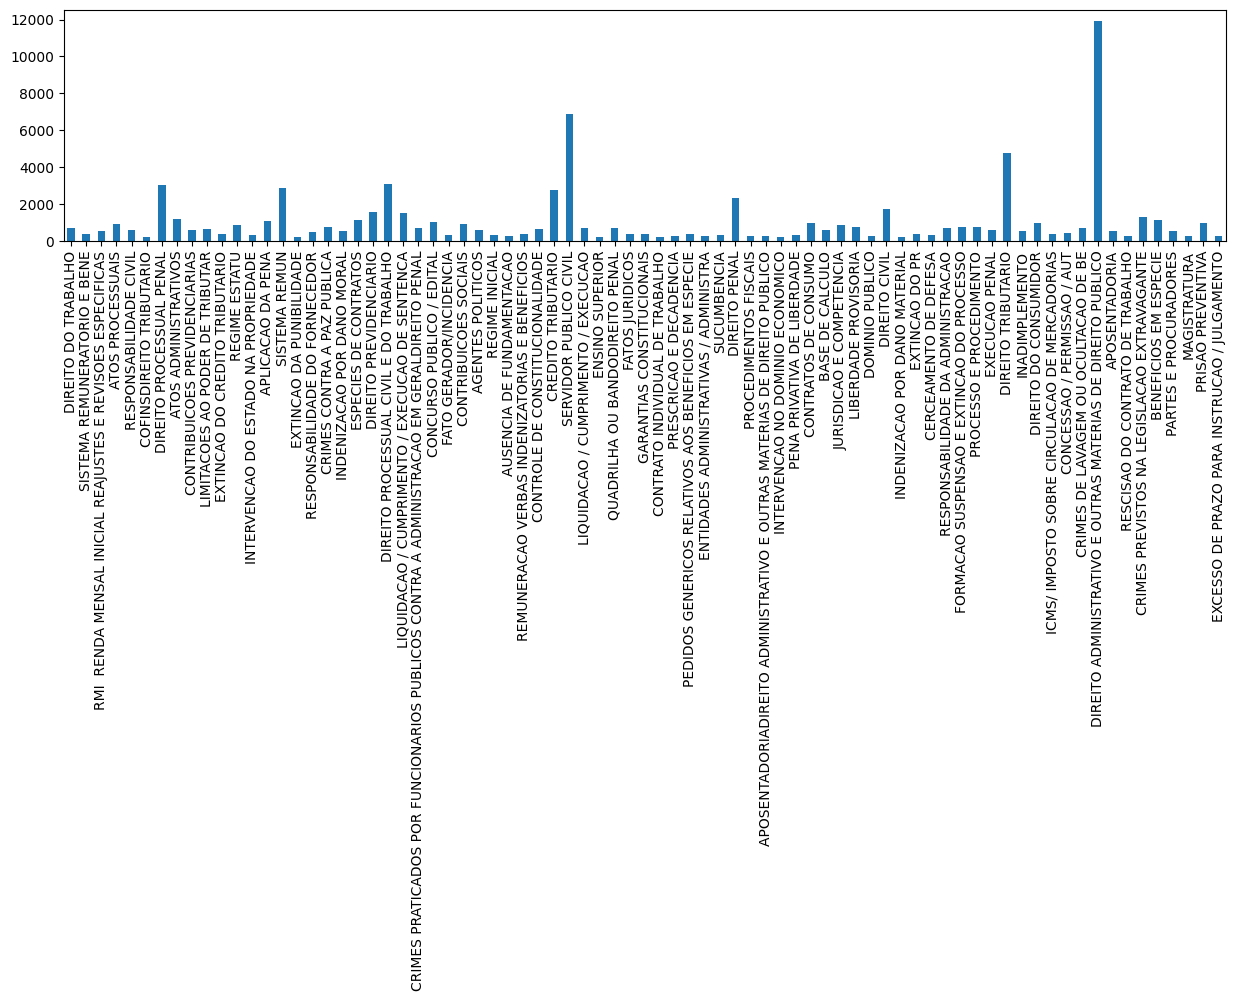

In [ ]:
# Distribuição das classes.
y_train_sample.sum().plot.bar(figsize=(15, 3))
plt.show()

# Separando um conjunto de validação

In [ ]:
mskf = MultilabelStratifiedKFold(n_splits=6, shuffle=True, random_state=0)

for train_index, test_index in mskf.split(X_train_sample, y_train_sample):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train_sample, X_val_sample = X_train_sample.iloc[train_index], X_train_sample.iloc[test_index]
   y_train_sample, y_val_sample = y_train_sample.iloc[train_index], y_train_sample.iloc[test_index]
   break

TRAIN: [    0     2     4 ... 29996 29997 29999] TEST: [    1     3     5 ... 29988 29990 29998]


In [ ]:
len(X_train_sample), len(X_val_sample)

(24976, 5024)

In [ ]:
len(y_train_sample), len(y_val_sample)

(24976, 5024)

In [ ]:
len(X_test_sample), len(y_test_sample)

(5000, 5000)

# Pré-processamento



In [ ]:
# Criando representações vetoriais (em formato de matriz TF-IDF) a partir dos textos
nltk.download("stopwords")

vectorizer = TfidfVectorizer(
    stop_words=stopwords.words("portuguese"),
    min_df=5
)

X_train_tf = vectorizer.fit_transform(X_train_sample.texto.to_list())
X_val_tf = vectorizer.transform(X_val_sample.texto.to_list())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Gerando embedings de modelos linguísticos
Rodar SOMENTE em casos onde os embeddings não puderem ser baixados anteriormente

In [ ]:
# #Instanciando modelo gerador de embeddings multilinguais
# multilingual_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# X_train_multilingual_embeddings = multilingual_model.encode(
#     X_train_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# X_val_multilingual_embeddings = multilingual_model.encode(
#     X_val_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# np.savez_compressed("X_train_multilingual_embeddings.npz", X_train_multilingual_embeddings)
# np.savez_compressed("X_val_multilingual_embeddings.npz", X_val_multilingual_embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/781 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
# # Instanciando modelo gerador de embeddings multilinguais
# multilingual2_model = SentenceTransformer('all-MiniLM-L6-v2')

# X_train_multilingual2_embeddings = multilingual2_model.encode(
#     X_train_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# X_val_multilingual2_embeddings = multilingual2_model.encode(
#     X_val_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# np.save("X_train_multilingual2_embeddings.npy", X_train_multilingual2_embeddings)
# np.save("X_val_multilingual2_embeddings.npy", X_val_multilingual2_embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/781 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
# X_test_multilingual_embeddings = multilingual_model.encode(
#     X_test_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# X_test_multilingual2_embeddings = multilingual2_model.encode(
#     X_test_sample.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# np.save("X_test_multilingual_embeddings.npy", X_test_multilingual_embeddings)
# np.save("X_test_multilingual2_embeddings.npy", X_test_multilingual2_embeddings)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

# Treinamento e avaliação dos modelos

In [ ]:
# Transformando vetores de classes para formato apropriado a esparso
s_Ytrain = sparse.csr_matrix(np.array(y_train_sample))
s_Yval = sparse.csr_matrix(np.array(y_val_sample))
s_Ytest = sparse.csr_matrix(np.array(y_test_sample))

In [ ]:
y_train.shape

(110186, 77)

### Treinando knn para embeddings multilinguais 1

In [ ]:
s_Xtrain = sparse.csr_matrix(X_train_multilingual_embeddings)
s_Xval = sparse.csr_matrix(X_val_multilingual_embeddings)

# Faixa de valores de k para testar
k_values = [10, 50, 100]

best_k = None
best_f1 = 0

for k in k_values:
    # Instancia o modelo com o valor atual de k
    classifier = MLkNN(k=k)

    # Treina o modelo nos dados de treinamento
    classifier.fit(s_Xtrain, s_Ytrain)

    # Faz predições no conjunto de validação
    predictions = classifier.predict(s_Xval)

    # Calcula o F1-Score no conjunto de validação
    f1 = f1_score(s_Yval, predictions, average="weighted")

    print(f"F1-Score para k={k}: {f1}")

    # Atualiza o melhor k com base no F1-Score
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Melhor k: {best_k} com F1-Score: {best_f1}")

# Treina o modelo final com o melhor k encontrado
final_classifier_1 = MLkNN(k=best_k)
final_classifier_1.fit(s_Xtrain, s_Ytrain)

KeyboardInterrupt: 

In [ ]:
# Criando embbedings dos dados de teste se tiver dado errado o download
# X_test_multilingual_embeddings = multilingual_model.encode(
#     X_test.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# np.save("X_test_multilingual_embeddings.npy", X_test_multilingual_embeddings)

s_Xtest = sparse.csr_matrix(X_test_multilingual_embeddings)

# # Avalia o modelo final no conjunto de teste
test_predictions = final_classifier_1.predict(s_Xtest)

print("F1-Score no Teste (weighted):", f1_score(s_Ytest, test_predictions, average="weighted"))
print("Relatório de Classificação no Teste:\n", classification_report(s_Ytest, test_predictions))

Batches:   0%|          | 0/1725 [00:00<?, ?it/s]

In [ ]:
del s_Xtrain
del s_Xval
del s_Ytrain
del s_Yval
del classifier
del predictions
gc.collect()

### Avaliando knn para embeddings multilinguais 2

In [ ]:
s_Xtrain = sparse.csr_matrix(X_train_multilingual2_embeddings)
s_Xval = sparse.csr_matrix(X_val_multilingual2_embeddings)

# Faixa de valores de k para testar
k_values = [10, 50, 100]

best_k = None
best_f1 = 0

for k in k_values:
    # Instancia o modelo com o valor atual de k
    classifier = MLkNN(k=k)

    # Treina o modelo nos dados de treinamento
    classifier.fit(s_Xtrain, s_Ytrain)

    # Faz predições no conjunto de validação
    predictions = classifier.predict(s_Xval)

    # Calcula o F1-Score no conjunto de validação
    f1 = f1_score(s_Yval, predictions, average="weighted")

    print(f"F1-Score para k={k}: {f1}")

    # Atualiza o melhor k com base no F1-Score
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Melhor k: {best_k} com F1-Score: {best_f1}")

# Treina o modelo final com o melhor k encontrado
final_classifier_2 = MLkNN(k=best_k)
final_classifier_2.fit(s_Xtrain, s_Ytrain)

In [ ]:
# Criando embbedings dos dados de teste se tiver dado errado o download
# X_test_multilingual2_embeddings = multilingual2_model.encode(
#     X_test.texto.to_list(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

# np.save("X_test_multilingual2_embeddings.npy", X_test_multilingual2_embeddings)

s_Xtest = sparse.csr_matrix(X_test_multilingual2_embeddings)

# Avalia o modelo final no conjunto de teste
test_predictions = final_classifier_2.predict(s_Xtest)

print("F1-Score no Teste (weighted):", f1_score(s_Ytest, test_predictions, average="weighted"))
print("Relatório de Classificação no Teste:\n", classification_report(s_Ytest, test_predictions))

Batches:   0%|          | 0/1725 [00:00<?, ?it/s]

In [ ]:
del s_Xtrain
del s_Xval
del s_Ytrain
del s_Yval
del classifier
del predictions
gc.collect()

### Avaliando knn matriz tf-idf

In [ ]:
# Faixa de valores de k para testar
k_values = [10, 50, 100]

best_k = None
best_f1 = 0

for k in k_values:
    # Instancia o modelo com o valor atual de k
    classifier = MLkNN(k=k)

    # Treina o modelo nos dados de treinamento
    classifier.fit(X_train_tf, s_Ytrain)

    # Faz predições no conjunto de validação
    predictions = classifier.predict(X_val_tf)

    # Calcula o F1-Score no conjunto de validação
    f1 = f1_score(s_Yval, predictions, average="weighted")

    print(f"F1-Score para k={k}: {f1}")

    # Atualiza o melhor k com base no F1-Score
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Melhor k: {best_k} com F1-Score: {best_f1}")

# Treina o modelo final com o melhor k encontrado
final_classifier_3 = MLkNN(k=best_k)
final_classifier_3.fit(X_train_tf, s_Ytrain)

In [ ]:
# Criando representações vetoriais (em formato de matriz TF-IDF) a partir dos textos
X_test_tf = vectorizer.fit_transform(X_test.texto.to_list())

# Avalia o modelo final no conjunto de teste
test_predictions = final_classifier_3.predict(X_test_tf)

print("F1-Score no Teste (weighted):", f1_score(s_Ytest, test_predictions, average="weighted"))
print("Relatório de Classificação no Teste:\n", classification_report(s_Ytest, test_predictions))